# JETSCAPE Summer School 2021: Bayesian parameter inference for a **relativistic heavy ion collision model**.

## Instructor: Dan Liyanage | The Ohio State University


In this notebook we will try to do a Bayesian Parameter Inference similar to what is in the recently published paper by **Derek Everett** and the JETSCAPE collaborators.

Relevant JETSCAPE papers:
- [Multi-system Bayesian constraints on the transport coefficients of QCD matter](https://arxiv.org/abs/2011.01430)
- [Phenomenological constraints on the transport properties of QCD matter with data-driven model averaging](https://arxiv.org/abs/2010.03928)

In the paper they consider multiple models and both RHIC and LHC data. But in this hands-on session, to keep things simple, we will only consider one model for relativistic heavy ion collisions and only the LHC experimental data. 

### JETSCAPE simulation framework

![Different stages of relativistic heavy ion collision](Results/FigureFiles/JETSCAPE.png)

### What's in This Notebook

>**1. Simulation data**
    - Load saved simulation data from a folder. Anyone who wish to use the code to do another Bayesian     analysis for relativistic heavy ion collision should do minor change to this section that suits    their model and simulation data.
            --Python modules used
                - pandas
    
>**2. Preprocessing of the simulation data**
    - We first standardize observables by removing the mean and scaling to unit variance. Then do a Principal Component Analysis (PCA) to reduce the dimensionality of the data. We keep only 10 PCs for the next steps of the analysis.
            --Python modules used
                - numpy, sklearn
                
>**3. Priors and experimental data**
    - We use uniform priors for this analysis. Relevant experimental data is also loaded from disk.
            --Python modules used
                - pandas

>**4. Building Emulators**
    - Since the simulations are computationally expensive we need surrogate models that can be trained on a sparse set of simulation data obtained from the full model and are then used to interpolate the model output speedily to any other point in the 20-dimensional parameter space. For this purpose we use Gaussian Processes and which also give the uncertainty in the prediction which is very important to properly account all uncertainties and reliably extract parameters using Bayesian methods. 
            --Python modules used
                - sklearn Gaussian Processors, numpy
                
>**5. Bayesian Parameter Estimation**
    - The Bayes theorem is used to find the posterior of the model parameters using the emulators and the experimental data.
            --Python modules used
                - pandas, numpy, seaborn

### Import all the necessary libraries

In [1]:
#import GPy
import sys
import os
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from numpy.linalg import inv
import sklearn, matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

import emcee
import ptemcee
#from emcee import PTSampler
import h5py
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
sns.set("notebook")

### Define some name variables

In [2]:
name="JETSCAPE_bayes"
#Saved emulator name
EMU='PbPb2760_emulators_scikit.dat'
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [3]:
# Define folder structure 

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

### 1. Simulation data.

In [4]:
# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")

In [5]:
design.shape

(485, 17)

In [6]:
design.head()

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
0,15.81754,-0.06769,0.98153,0.92763,2.61235,1.34389,0.00988,0.21946,-0.28087,0.49299,0.10715,0.14627,0.19076,0.09729,0.15270,4.79271,0.14759
1,13.43970,0.12337,1.34278,1.10651,2.17324,0.90060,0.05149,0.23432,-0.37329,0.29940,0.08497,0.12393,0.20455,0.07722,0.29229,5.81536,0.14498
2,15.84174,0.13791,1.06155,1.15276,2.77641,1.03337,0.00518,0.23255,-0.35375,0.79445,0.13705,0.11665,0.18175,0.07408,0.07515,3.39156,0.15274
3,14.47395,0.11147,0.82684,1.01294,2.40816,1.13235,-0.08793,0.20885,-1.19838,0.43428,0.12346,0.07759,0.17377,0.06128,0.11686,4.61781,0.14550
4,16.13648,0.32229,1.38858,0.84729,1.23917,1.12739,-0.07829,0.23634,-0.22399,0.27735,0.14276,0.11019,0.20315,0.07877,-0.10924,6.42583,0.13879


![Different stages of relativistic heavy ion collision](Results/FigureFiles/Trento_param.png)

![Different stages of relativistic heavy ion collision](Results/FigureFiles/viscosity_param.png)

#### Figure credits : Derek Everett

In [7]:
#Simulation outputs at the design points
simulation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_simulation")

In [8]:
simulation.shape

(485, 110)

In [9]:
simulation.head()

,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,1608.155095,1301.879222,953.021576,645.307009,402.420100,244.321593,138.775810,64.998956,2094.094369,1854.027153,...,0.027231,0.030437,0.032241,0.034078,0.010554,0.012550,0.014681,0.017421,0.019349,0.018653
1,1376.107143,1141.792044,896.336877,634.080481,398.155003,253.422222,146.311755,75.674266,1718.904855,1568.418976,...,0.025072,0.025309,0.027655,0.025310,0.009541,0.009735,0.011988,0.012579,0.013068,0.012530
2,1715.649143,1410.970524,1075.089936,734.002033,495.888734,315.102365,182.456817,93.457043,2165.629760,1945.260785,...,0.020419,0.021284,0.021178,0.022446,0.008585,0.009366,0.008328,0.009645,0.010275,0.010419
3,1474.812429,1198.535444,919.375636,646.697544,439.662816,280.593073,160.003266,79.338320,1927.358731,1727.315725,...,0.019061,0.020970,0.024026,0.023602,0.007337,0.008606,0.010254,0.010787,0.012219,0.011568
4,1625.855467,1369.550286,1065.824673,726.855338,504.200066,322.735247,190.869785,100.375664,2156.410538,1920.777164,...,0.025223,0.028049,0.029004,0.029121,0.010363,0.011207,0.011285,0.012834,0.012702,0.014524


![Different stages of relativistic heavy ion collision](Results/FigureFiles/observables.png)

#### Figure credits : Derek Everett

In [10]:
X = design.values
Y = simulation.values

In [11]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 17)
Y.shape : (485, 110)


In [12]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

### 2. Preprocessing of the simulation data.

In [13]:
#Scaling the data to be zero mean and unit variance for each observables
SS  =  StandardScaler(copy=True)

In [14]:
#Singular Value Decomposition
u, s, vh = np.linalg.svd(SS.fit_transform(Y), full_matrices=True)
print(f'shape of u {u.shape} shape of s {s.shape} shape of vh {vh.shape}')

shape of u (485, 485) shape of s (110,) shape of vh (110, 110)


### How many Principal Components should we keep?

/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  del sys.path[0]


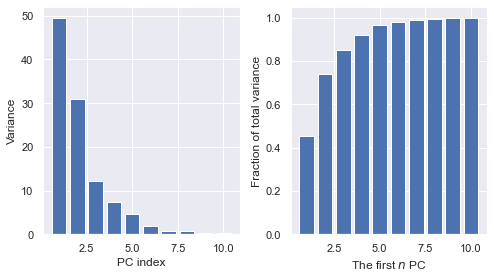

In [15]:
# print the explained raito of variance
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,4))
#importance = pca_analysis.explained_variance_
importance = np.square(s[:10]/math.sqrt(u.shape[0]-1))
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
plt.tight_layout(True)

In [16]:
#whiten and project data to principal component axis (only keeping first 10 PCs)
pc_tf_data=u[:,0:10] * math.sqrt(u.shape[0]-1)
#Scale Transformation from PC space to original data space
inverse_tf_matrix= np.diag(s[0:10]) @ vh[0:10,:] * SS.scale_.reshape(1,110)/ math.sqrt(u.shape[0]-1)

### 3. Load priors and experimental data.

In [17]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [18]:
prior_df.head()

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
min,10.0,-0.7,0.3,0.5,0.000,0.3,-0.3,0.13,-2.0,-1.0,0.01,0.01,0.12,0.025,-0.8,2.0,0.130
max,20.0,0.7,2.0,1.5,4.913,2.0,0.3,0.30,1.0,2.0,0.20,0.20,0.30,0.150,0.8,8.0,0.165


In [19]:
experiment=pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_experiment",index_col=0)
experiment.head()
y_exp=experiment.loc['mean'].values
y_exp_variance=experiment.loc['variance'].values
print(f'Shape of the experiment observables {y_exp.shape} and shape of the experimental error variance{y_exp_variance.shape}')

Shape of the experiment observables (110,) and shape of the experimental error variance(110,)


### Plot the experimental data

In [20]:
from collections import OrderedDict

colors = OrderedDict([
    ('blue', '#4e79a7'),
    ('orange', '#f28e2b'),
    ('green', '#59a14f'),
    ('red', '#e15759'),
    ('cyan', '#76b7b2'),
    ('purple', '#b07aa1'),
    ('brown', '#9c755f'),
    ('yellow', '#edc948'),
    ('pink', '#ff9da7'),
    ('gray', '#bab0ac')
])

fontsize = dict(
    large=11,
    normal=10,
    small=9,
    tiny=8
)

offblack = '.15'

plt.rcdefaults()
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Lato'],
    'mathtext.fontset': 'custom',
    'mathtext.default': 'it',
    'mathtext.rm': 'sans',
    'mathtext.it': 'sans:italic:medium',
    'mathtext.cal': 'sans',
    'font.size': fontsize['normal'],
    'legend.fontsize': fontsize['normal'],
    'axes.labelsize': fontsize['normal'],
    'axes.titlesize': fontsize['large'],
    'xtick.labelsize': fontsize['small'],
    'ytick.labelsize': fontsize['small'],
    #'font.weight': 400,
    'axes.labelweight': 400,
    'axes.titleweight': 400,
    'axes.prop_cycle': plt.cycler('color', list(colors.values())),
    'lines.linewidth': .8,
    'lines.markersize': 3,
    'lines.markeredgewidth': 0,
    'patch.linewidth': .8,
    'axes.linewidth': .6,
    'xtick.major.width': .6,
    'ytick.major.width': .6,
    'xtick.minor.width': .4,
    'ytick.minor.width': .4,
    'xtick.major.size': 3.,
    'ytick.major.size': 3.,
    'xtick.minor.size': 2.,
    'ytick.minor.size': 2.,
    'xtick.major.pad': 3.5,
    'ytick.major.pad': 3.5,
    'axes.labelpad': 4.,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'text.color': offblack,
    'axes.edgecolor': offblack,
    'axes.labelcolor': offblack,
    'xtick.color': offblack,
    'ytick.color': offblack,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})

def set_tight(fig=None, **kwargs):
    """
    Set tight_layout with a better default pad.

    """
    if fig is None:
        fig = plt.gcf()

    kwargs.setdefault('pad', .1)
    fig.set_tight_layout(kwargs)

In [21]:
# 8 bins
ALICE_cent_bins = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]]) 

obs_cent_list = {
'Pb-Pb-2760': {
    'dNch_deta' : ALICE_cent_bins,
    'dET_deta' : np.array([[0, 2.5], [2.5, 5], [5, 7.5], [7.5, 10],
                           [10, 12.5], [12.5, 15], [15, 17.5], [17.5, 20],
                           [20, 22.5], [22.5, 25], [25, 27.5], [27.5, 30],
                           [30, 32.5], [32.5, 35], [35, 37.5], [37.5, 40],
                           [40, 45], [45, 50], [50, 55], [55, 60],
                           [60, 65], [65, 70]]), # 22 bins
    'dN_dy_pion'   : ALICE_cent_bins,
    'dN_dy_kaon'   : ALICE_cent_bins,
    'dN_dy_proton' : ALICE_cent_bins,
    'dN_dy_Lambda' : np.array([[0,5],[5,10],[10,20],[20,40],[40,60]]), # 5 bins
    'dN_dy_Omega'  : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'dN_dy_Xi'     : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'mean_pT_pion'   : ALICE_cent_bins,
    'mean_pT_kaon'   : ALICE_cent_bins,
    'mean_pT_proton' : ALICE_cent_bins,
    'pT_fluct' : np.array([[0,5],[5,10],[10,15],[15,20], [20,25],[25,30],[30,35],[35,40], [40,45],[45,50],[50,55],[55,60]]), #12 bins
    'v22' : ALICE_cent_bins,
    'v32' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    'v42' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    }
}

In [22]:
obs_groups = {'yields' : ['dNch_deta', 'dET_deta', 'dN_dy_pion', 'dN_dy_kaon', 'dN_dy_proton'],
              'mean_pT' : ['mean_pT_pion', 'mean_pT_kaon','mean_pT_proton', ],
              'fluct' : ['pT_fluct'],
              'flows' : ['v22', 'v32', 'v42']}

obs_group_labels = {'yields' : r'$dN_\mathrm{id}/dy_p$, $dN_\mathrm{ch}/d\eta$, $dE_T/d\eta$ [GeV]',
                    'mean_pT' : r'$ \langle p_T \rangle_\mathrm{id}$' + ' [GeV]',
                    'fluct' : r'$\delta p_{T,\mathrm{ch}} / \langle p_T \rangle_\mathrm{ch}$',
                    'flows' : r'$v^{(\mathrm{ch})}_k\{2\} $'}

colors = ['b', 'g', 'r', 'c', 'm', 'tan', 'gray']

obs_tex_labels = {'dNch_deta' : r'$dN_\mathrm{ch}/d\eta$' + ' x 2',
                  'dN_dy_pion' : r'$dN_{\pi}/dy_p$',
                  'dN_dy_kaon' : r'$dN_{K}/dy_p$',
                  'dN_dy_proton' : r'$dN_{p}/dy_p$',
                  'dET_deta' : r'$dE_{T}/d\eta$' + ' x 5',
                  
                  'mean_pT_proton' : r'$\langle p_T \rangle_p$',
                  'mean_pT_kaon' : r'$\langle p_T \rangle_K$',
                  'mean_pT_pion' : r'$\langle p_T \rangle_\pi$',
                 
                  'pT_fluct' : None,
                  'v22' : r'$v^{(\mathrm{ch})}_2\{2\}$',
                  'v32' : r'$v^{(\mathrm{ch})}_3\{2\}$',
                  'v42' : r'$v^{(\mathrm{ch})}_4\{2\}$'}

In [23]:
index={}
st_index=0
for obs_group in  obs_groups.keys():
    for obs in obs_groups[obs_group]:
        #print(obs)
        n_centrality= len(obs_cent_list['Pb-Pb-2760'][obs])
        #print(n_centrality)
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index+n_centrality
print(index)

{'dNch_deta': [0, 8], 'dET_deta': [8, 30], 'dN_dy_pion': [30, 38], 'dN_dy_kaon': [38, 46], 'dN_dy_proton': [46, 54], 'mean_pT_pion': [54, 62], 'mean_pT_kaon': [62, 70], 'mean_pT_proton': [70, 78], 'pT_fluct': [78, 90], 'v22': [90, 98], 'v32': [98, 104], 'v42': [104, 110]}


No handles with labels found to put in legend.
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Done


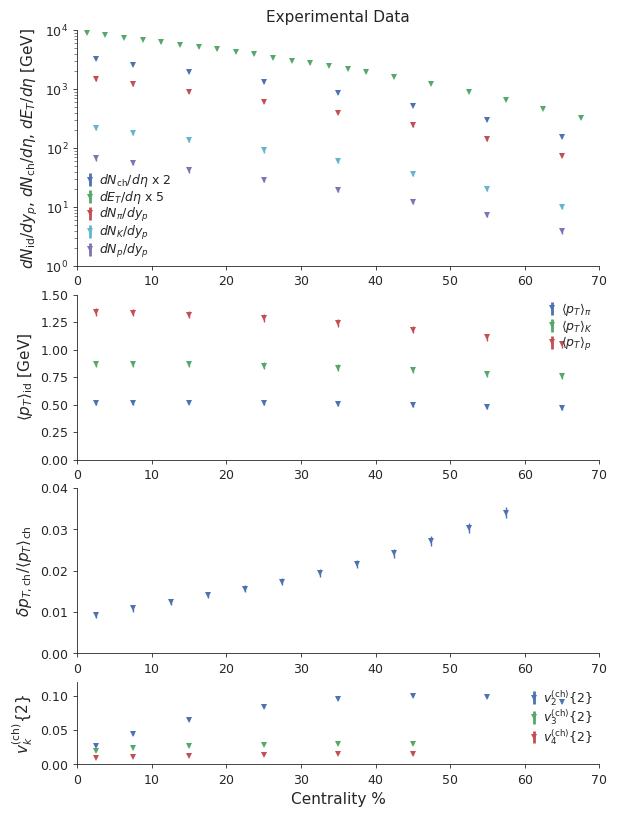

In [24]:
# height_ratios = [1.8, 1.2, 1.5, 1.]
height_ratios = [2, 1.4, 1.4, 0.7]
column = 1
fig, axes = plt.subplots(nrows=4, ncols=column, figsize=(6, 8), squeeze=False, 
                         gridspec_kw={'height_ratios': height_ratios})

for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row][0].tick_params(labelsize=9)
       # axes[row][1].tick_params(labelsize=9)
        
        scale = 1.0
        
        if obs_group == 'yields':
            axes[row][0].set_yscale('log')
          #  axes[row][1].set_yscale('log')
            
            axes[row][0].set_title("Experimental Data", fontsize = 11)
          #  axes[row][1].set_title("VAH + PTMA", fontsize = 11)
           
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row][0].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        #Y1 = Ymodel1['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr1 = Ymodel1['Pb-Pb-2760'][obs]['err'][0][0]
        
        #Y2 = Ymodel2['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr2 = Ymodel2['Pb-Pb-2760'][obs]['err'][0][0]
        
        label = obs_tex_labels[obs]
            
       # axes[row][0].plot(x, Y1*scale, color = color, label = label, lw = 1.5)
       # axes[row][0].fill_between(x, (Y1-Yerr1)*scale, (Y1+Yerr1)*scale, color=color, alpha=0.2)
        
       # axes[row][1].plot(x, Y2*scale, color = color, label = label, lw = 1.5)
       # axes[row][1].fill_between(x, (Y2-Yerr2)*scale, (Y2+Yerr2)*scale, color=color, alpha=0.2)
        
        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])
        #exp_mean = Yexp['Pb-Pb-2760'][obs]['mean'][0]
        #exp_err = Yexp['Pb-Pb-2760'][obs]['err'][0]
    
        axes[row][0].errorbar(x, exp_mean*scale, exp_err, color=color, fmt='v', markersize='4', elinewidth=1, label=label)
        #axes[row][1].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
            

        
    leg = axes[row][0].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row][0].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row][0].set_ylim(1, 1e4)
       # axes[row][1].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row][0].set_ylim(0., 1.5)
       # axes[row][1].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row][0].set_ylim(0.0, 0.04)
      #  axes[row][1].set_ylim(0.0, 0.04)
    if obs_group == 'flows':
        axes[row][0].set_ylim(0.0, 0.12)
       # axes[row][1].set_ylim(0.0, 0.12)
    if axes[row][0].is_last_row():
        axes[row][0].set_xlabel('Centrality %', fontsize = 11)
       # axes[row][1].set_xlabel('Centrality %', fontsize = 11)
        
plt.tight_layout(True)
# set_tight(fig, rect=[0, 0, 1, 0.95])
set_tight(fig, rect=[0, 0, 1, 1])
fig.savefig("Experimental_data.png", dpi=300)

print("Done")




### 4. Building emulators

In [25]:
design_max=prior_df.loc['max'].values
design_min=prior_df.loc['min'].values

In [26]:
import time
design=X
overide=False
input_dim=len(design_max)
ptp = design_max - design_min
bound=zip(design_min,design_max)
if (os.path.exists(data_path(EMU))) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,10):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=ptp,length_scale_bounds=np.outer(ptp, (4e-1, 1e2)))+ krnl.WhiteKernel(noise_level=.1, noise_level_bounds=(1e-2, 1e2))
        GPR=gpr(kernel=kernel,n_restarts_optimizer=4,alpha=0.0000000001)
        GPR.fit(design,pc_tf_data[:,i].reshape(-1,1))
        print(f'GPR score is {GPR.score(design,pc_tf_data[:,i])} \n')
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("--- %s seconds ---" % (time.time() - start_time))
        Emulators.append(GPR)

if (overide==True) or not(os.path.exists(data_path(EMU))):
    with open(data_path(EMU),"wb") as f:
        pickle.dump(Emulators,f)

Saved emulators exists and overide is prohibited


In [27]:
def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 17 model parametrs.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=17:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        theta=np.array(theta).reshape(1,17)
        for i in range(0,10):
            mn,std=Emulators[i].predict(theta,return_std=True)
            mean.append(mn)
            variance.append(std**2)
    mean=np.array(mean).reshape(1,-1)
    inverse_transformed_mean=mean @ inverse_tf_matrix + np.array(SS.mean_).reshape(1,-1)
    variance_matrix=np.diag(np.array(variance).flatten())
    A_p=inverse_tf_matrix
    inverse_transformed_variance=np.einsum('ik,kl,lj-> ij', A_p.T, variance_matrix, A_p, optimize=False)
    return inverse_transformed_mean, inverse_transformed_variance

### Homework Exercise
To keep this notebook short we have omitted some of the essential checks in any Bayesian Parameter Inference task. Can you try to build these steps on your own?
 - Emulator validation
 - Prior predictive checks
 - Closure test

### 5. Bayesian parameter inference

In [30]:
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

In [31]:
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
  #  print(L.diagonal())
    a=np.ones(len(L.diagonal()))*1e-10
    #print(a)
    #print(L)
   # L=L+np.diag(a)
    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

In [32]:
# Covariance truncation error from PC is not yet included
def log_posterior(model_parameters):
    mn,var=predict_observables(model_parameters)
    delta_y=mn-y_exp.reshape(1,-1)
    delta_y=delta_y.flatten()
    
    exp_var=np.diag(y_exp_variance)
    
    total_var=var + exp_var
    #only_diagonal=np.diag(total_var.diagonal())
    return log_prior(model_parameters) + mvn_loglike(delta_y,total_var)

In [33]:
# Covariance truncation error from PC is not yet included
def log_like(model_parameters):
    mn,var=predict_observables(model_parameters)
    delta_y=mn-y_exp.reshape(1,-1)
    delta_y=delta_y.flatten()
    
    exp_var=np.diag(y_exp_variance)
    
    total_var=var + exp_var
    #only_diagonal=np.diag(total_var.diagonal())
    return mvn_loglike(delta_y,total_var)

In [34]:
#log_posterior(MAP_params['Pb-Pb-2760'])

In [35]:
# Here we actually perform the MCMC Sampling
filename = data_path(name+'ptemcee')
# 1. Define the parameters
run_mcmc = False
ntemps=25
Tmax = 1e3

nwalkers = 200 # Typically 10*ndim
ndim = 17
nburnin = 1000 # The number of steps it takes for the walkers to thermalize
niterations= 5000 # The number of samples to draw once thermalized
nthin = 10 # Record every nthin-th iteration

nthreads = 5 # Easy parallelization! 

min_theta = [1.625] # Lower bound for initializing walkers
max_theta = [24.79] # Upper bound for initializing walkers

if run_mcmc:

    # 2. Instantiate the sampler object with the parameters, data, likelihood, and prior.
    
    #sampler=PTSampler(ntemps, nwalkers, ndim, logl, logp, threads=nthreads, betas=betas)
    ptsampler_ex=ptemcee.Sampler(nwalkers, ndim, log_like, log_prior, ntemps, 
                      threads=nthreads, Tmax=Tmax)

    # 3. Initialize the walkers at random positions in our 99% prior range
    pos0 = design_min + (design_max - design_min) * np.random.rand(ntemps, nwalkers, ndim)

    # 4. Run the sampler's burn-in iterations
    print("Running burn-in phase")
    for p, lnprob, lnlike in ptsampler_ex.sample(pos0, iterations=nburnin,adapt=True):
        pass
    ptsampler_ex.reset() # Discard previous samples from the chain, but keep the position

    print("Running MCMC chains")
    # 5. Now we sample for nwalkers*niterations, recording every nthin-th sample
    for p, lnprob, lnlike in ptsampler_ex.sample(p, iterations=niterations, thin=nthin,adapt=True):
        pass 

    print('Done MCMC')

    mean_acc_frac = np.mean(ptsampler_ex.acceptance_fraction)
    print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
          f"(in total {nwalkers*niterations} steps)")
    
    # We only analyze the zero temperature MCMC samples
    
    #np.save(name+'ptemcee', )
   # closure_ex_chain = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples_df= pd.DataFrame(samples, columns=model_param_dsgn)
    samples_df.to_csv(filename)
else:
    samples_df = pd.read_csv(filename, index_col=0)
    
et = time.time()
#print(f'Time it took to generate MCMC chain {et-st}')

In [36]:
samples_df.shape

(100000, 17)

In [37]:
samples_df.head()

,$N$[$2.76$TeV],$p$,$\sigma_k$,$w$ [fm],$d_{\mathrm{min}}$ [fm],$\tau_R$ [fm/$c$],$\alpha$,"$T_{\eta,\mathrm{kink}}$ [GeV]","$a_{\eta,\mathrm{low}}$ [GeV${}^{-1}$]","$a_{\eta,\mathrm{high}}$ [GeV${}^{-1}$]",$(\eta/s)_{\mathrm{kink}}$,$(\zeta/s)_{\max}$,"$T_{\zeta,c}$ [GeV]",$w_{\zeta}$ [GeV],$\lambda_{\zeta}$,$b_{\pi}$,$T_{\mathrm{sw}}$ [GeV]
0,15.380569,-0.080693,1.447961,0.937012,1.635781,0.698563,0.060161,0.210777,0.412134,-0.766091,0.187662,0.132007,0.195914,0.065353,0.689512,3.270709,0.145179
1,15.152515,-0.093894,0.793104,1.281809,0.786307,1.706157,0.133076,0.231199,-1.164645,-0.941964,0.023837,0.106328,0.182774,0.060440,-0.553702,5.524785,0.135236
2,13.914964,0.122687,0.956706,1.038289,0.027940,1.283597,0.066023,0.268340,-0.351511,1.174594,0.082084,0.084520,0.157131,0.067873,-0.116463,6.404851,0.138855
3,13.733903,-0.178527,1.007123,0.902356,0.901309,1.298028,-0.001200,0.211640,-0.207327,0.455268,0.159842,0.096154,0.142026,0.066798,0.696567,4.876026,0.139435
4,14.323288,0.104647,0.981031,0.997697,0.347131,1.283085,0.011991,0.245523,0.040774,0.553672,0.119725,0.169319,0.256251,0.057341,-0.154465,5.226807,0.141202


### Homework exercise
 - Can you perform some MCMC diagnostic tests that you know on these posterior chains?

#### Find MAP

In [38]:
find_map_param = False
if find_map_param == True:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    rslt = optimize.differential_evolution(lambda x: -log_posterior(x), 
                                           bounds=bounds,
                                           maxiter=10000,
                                          disp=True,
                                          tol=1e-9,
                                         )
    print(rslt.x)

In [39]:
map_values_saved = np.array([ 1.43084321e+01, 8.51008023e-03, 9.41234451e-01, 9.97949538e-01
  ,2.41892020e-01 , 1.38963776e+00 , 7.02342164e-02 , 2.27110367e-01
 ,-1.01966830e-01, -3.53567209e-01 , 1.33301368e-01 , 1.13638421e-01
  ,1.88569996e-01 , 1.08392032e-01 , 6.00537669e-02 , 5.76620758e+00
  ,1.35064848e-01])

In [41]:
mm,vv=predict_observables(map_values_saved)
print(f'Shape of mean {mm.shape} and variance {vv.shape}')

Shape of mean (1, 110) and variance (110, 110)


### Posterior distributions

In [ ]:
#np.divide(map_values_saved,MAP_params['Pb-Pb-2760'])

In [42]:
sns.color_palette('bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

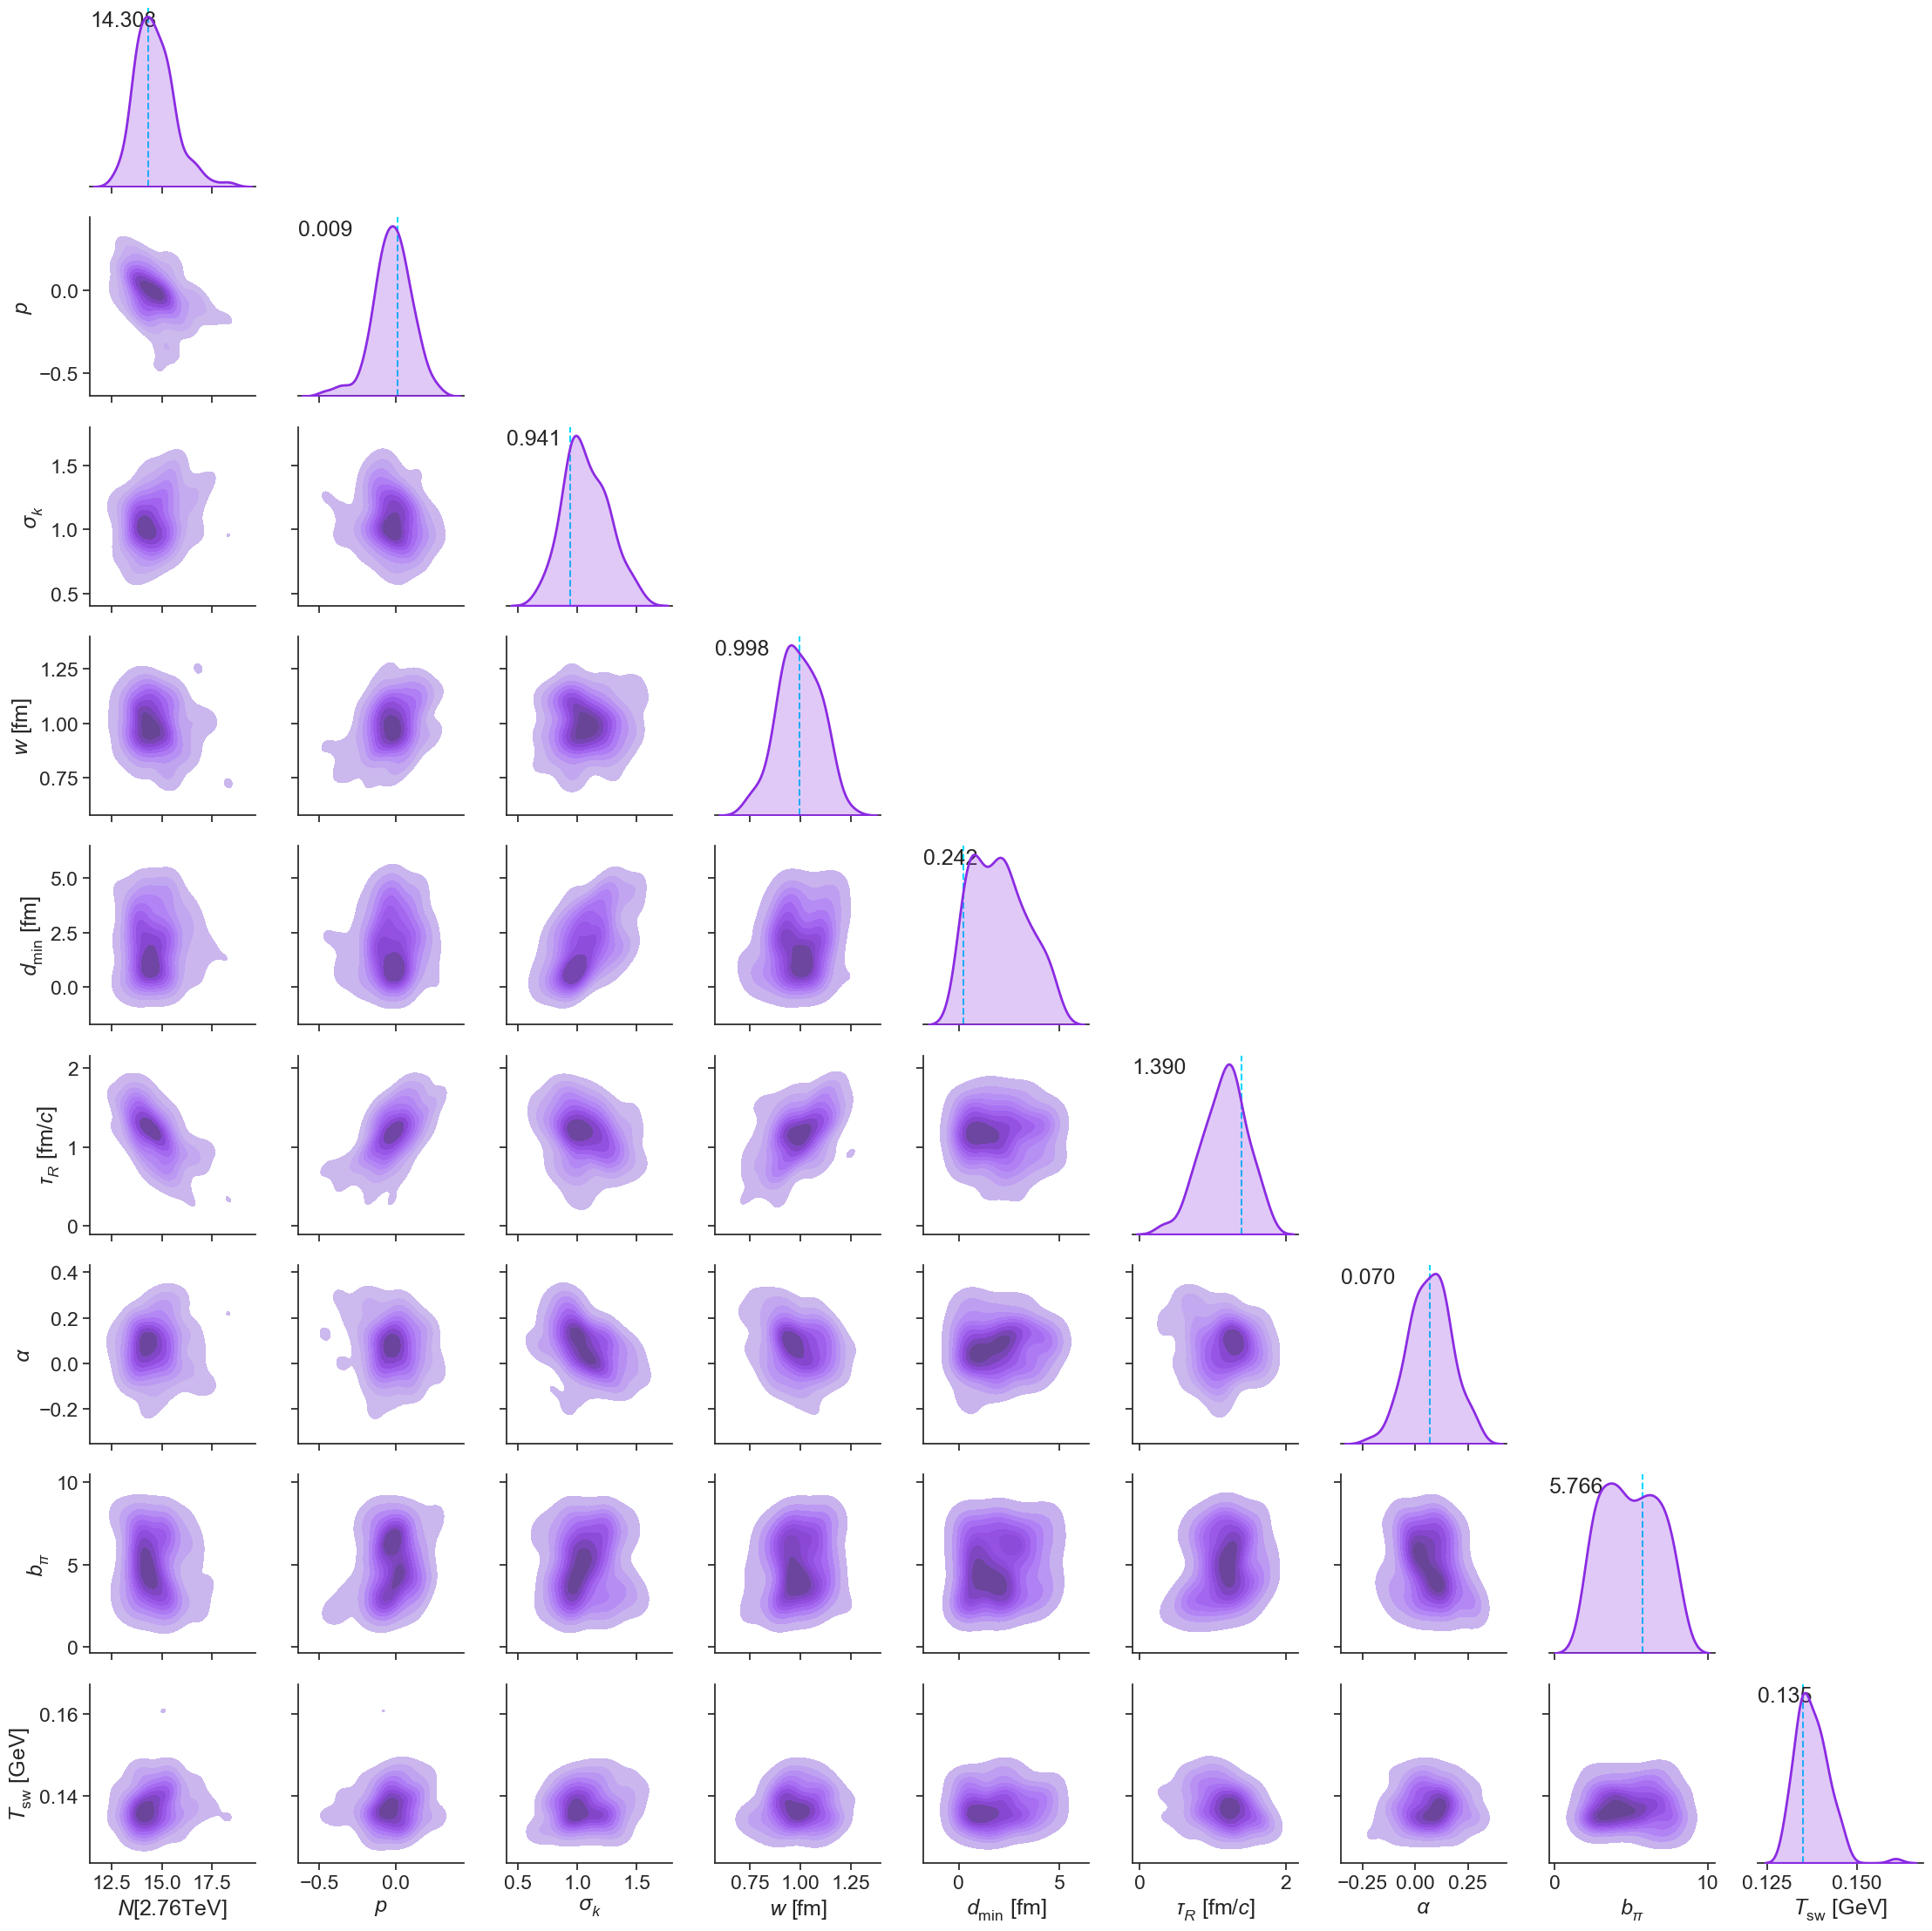

In [51]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
map_parameters=map_values_saved.flatten()
n_samples_prior = 100000
prune = 1000
#map_parameters = rslt.x
sns.set_palette('bright')
observables_to_plot=[0, 1, 2 ,3 , 4, 5, 6, 15, 16]
g = sns.PairGrid(samples_df.iloc[0:n_samples_prior:prune,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.kdeplot, color=sns.color_palette()[4], fill=True)
#g.map_upper(sns.kdeplot, shade=True, color=sns.color_palette()[0])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[4])
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[9])
    ax.text(0,0.9,s= f'{map_parameters[i]:.3f}', transform=ax.transAxes)

plt.tight_layout()
save_fig(name+"partial")
plt.show()

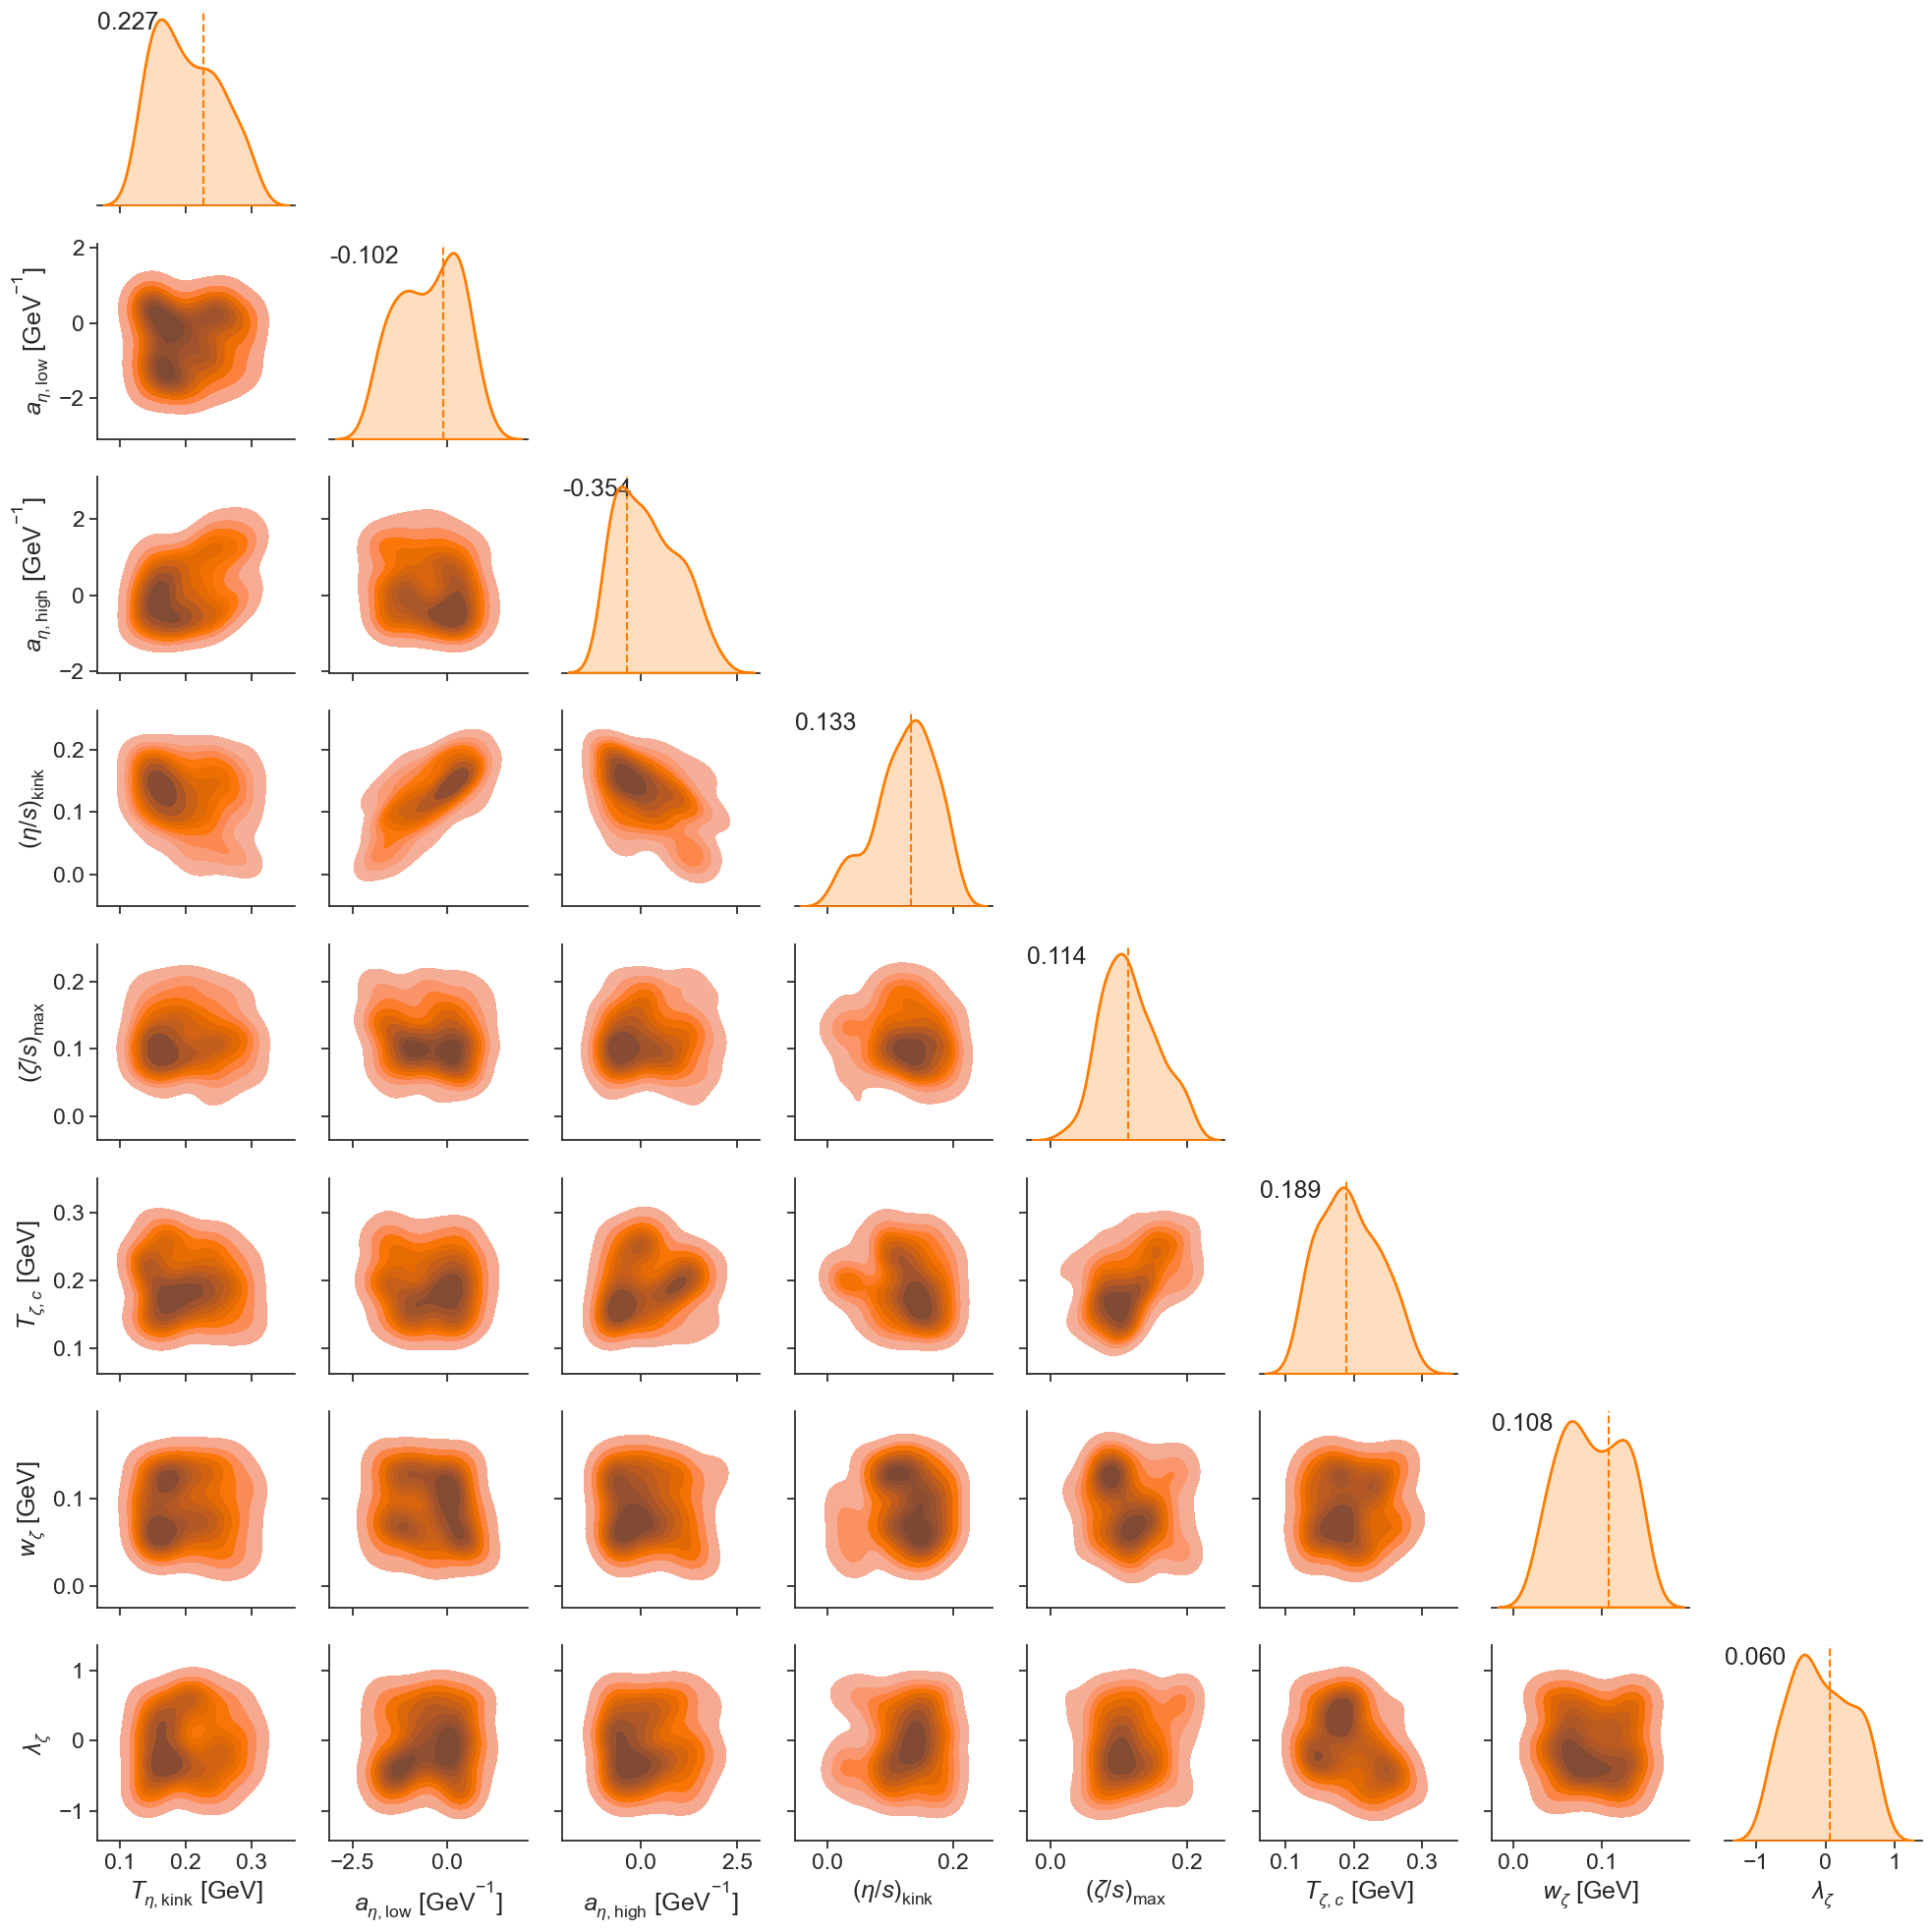

In [52]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")
#map_parameters = rslt.x
n_samples_prior = 100000
prune = 1000
map_parameters=map_values_saved.flatten()
sns.set_palette('bright')
observables_to_plot=[7, 8 , 9, 10, 11, 12, 13, 14]
g = sns.PairGrid(samples_df.iloc[0:n_samples_prior:prune,observables_to_plot], corner=True, diag_sharey=False)
g.map_lower(sns.kdeplot, color=sns.color_palette()[5], fill=True)
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[1], fill=True)
for n,i in enumerate(observables_to_plot):
    ax=g.axes[n][n]
    ax.axvline(x=map_parameters[i], ls='--', c=sns.color_palette()[1])
    ax.text(0,0.9,s= f'{map_parameters[i]:.3f}', transform=ax.transAxes)

plt.tight_layout()
save_fig(name+"viscous")
plt.show()

### MAP predictions compared to experimental observables

No handles with labels found to put in legend.
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


Done


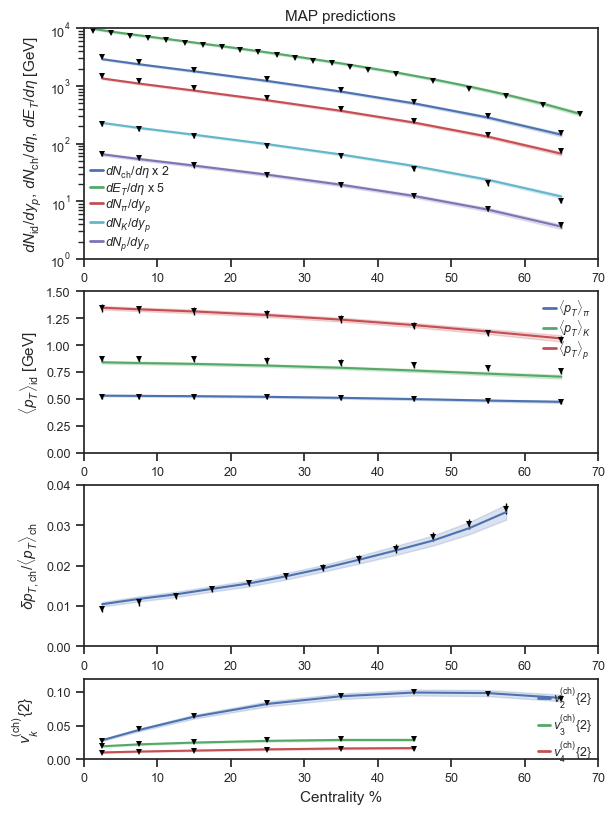

In [46]:
# height_ratios = [1.8, 1.2, 1.5, 1.]
height_ratios = [2, 1.4, 1.4, 0.7]
column = 1
fig, axes = plt.subplots(nrows=4, ncols=column, figsize=(6, 8), squeeze=False, 
                         gridspec_kw={'height_ratios': height_ratios})

for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row][0].tick_params(labelsize=9)
       # axes[row][1].tick_params(labelsize=9)
        
        scale = 1.0
        
        if obs_group == 'yields':
            axes[row][0].set_yscale('log')
          #  axes[row][1].set_yscale('log')
            
            axes[row][0].set_title("MAP predictions", fontsize = 11)
          #  axes[row][1].set_title("VAH + PTMA", fontsize = 11)
           
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row][0].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        Y1 = mm[0,index[obs][0]:index[obs][1]]
        Yerr1 = np.sqrt(vv.diagonal()[index[obs][0]:index[obs][1]])
        
        #Y2 = Ymodel2['Pb-Pb-2760'][obs]['mean'][0][0]
        #Yerr2 = Ymodel2['Pb-Pb-2760'][obs]['err'][0][0]
        
        label = obs_tex_labels[obs]
            
        axes[row][0].plot(x, Y1*scale, color = color, label = label, lw = 1.5)
        axes[row][0].fill_between(x, (Y1-Yerr1)*scale, (Y1+Yerr1)*scale, color=color, alpha=0.2)
        
       # axes[row][1].plot(x, Y2*scale, color = color, label = label, lw = 1.5)
       # axes[row][1].fill_between(x, (Y2-Yerr2)*scale, (Y2+Yerr2)*scale, color=color, alpha=0.2)
        
        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])
        #exp_mean = Yexp['Pb-Pb-2760'][obs]['mean'][0]
        #exp_err = Yexp['Pb-Pb-2760'][obs]['err'][0]
    
        axes[row][0].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
        #axes[row][1].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
            

        
    leg = axes[row][0].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row][0].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row][0].set_ylim(1, 1e4)
       # axes[row][1].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row][0].set_ylim(0., 1.5)
       # axes[row][1].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row][0].set_ylim(0.0, 0.04)
      #  axes[row][1].set_ylim(0.0, 0.04)
    if obs_group == 'flows':
        axes[row][0].set_ylim(0.0, 0.12)
       # axes[row][1].set_ylim(0.0, 0.12)
    if axes[row][0].is_last_row():
        axes[row][0].set_xlabel('Centrality %', fontsize = 11)
       # axes[row][1].set_xlabel('Centrality %', fontsize = 11)
        
plt.tight_layout(True)
# set_tight(fig, rect=[0, 0, 1, 0.95])
set_tight(fig, rect=[0, 0, 1, 1])
fig.savefig("MAP_prediction.png", dpi=300)

print("Done")





### Posterior for the viscosities

#### Define temperature dependent viscosity functions

In [47]:
def zeta_over_s(T, zmax, T0, width, asym):
    DeltaT = T - T0
    sign = 1 if DeltaT>0 else -1
    x = DeltaT/(width*(1.+asym*sign))
    return zmax/(1.+x**2)
zeta_over_s = np.vectorize(zeta_over_s)

def eta_over_s(T, T_k, alow, ahigh, etas_k):
    if T < T_k:
        y = etas_k + alow*(T-T_k)
    else:
        y = etas_k + ahigh*(T-T_k)
    if y > 0:
        return y
    else:
        return 0.
eta_over_s = np.vectorize(eta_over_s)

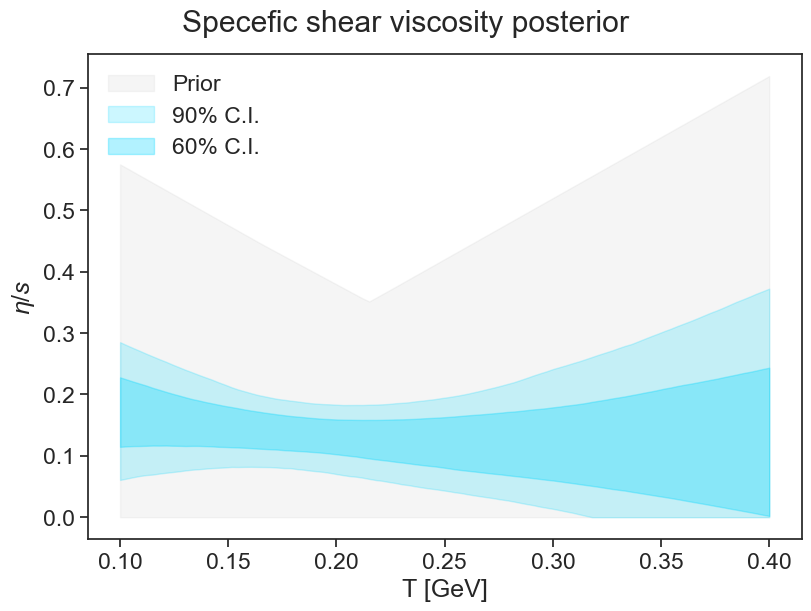

In [86]:
Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic shear viscosity posterior", wrap=True)

prior_etas = []

for row in np.random.uniform(design_min, design_max,(10000,17))[:,[7,8,9,10]]:
    [T_k, alow, ahigh, etas_k] = row
    prior=[]
    for T in Tt:
        prior.append(eta_over_s(T,T_k,alow,ahigh,etas_k))
    prior_etas.append(prior)
per0_pr,per5_pr,per20_pr,per80_pr,per95_pr,per100_pr=np.percentile(prior_etas,[0,5,20,80,95,100], axis=0)

n_samples_posterior = 100000
prune = 10
posterior_etas = []
    
for row in samples_df.iloc[0:n_samples_posterior:prune,[7,8,9,10]].values:
    [T_k, alow, ahigh, etas_k] = row
    posterior=[]
    for T in Tt:
        posterior.append(eta_over_s(T,T_k,alow,ahigh,etas_k))
    posterior_etas.append(posterior)
per0,per5,per20,per80,per95,per100=np.percentile(posterior_etas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0_pr,per100_pr,color=sns.color_palette()[7], alpha=0.1, label='Prior')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[9], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[9], alpha=0.3, label='60% C.I.')
#pos=np.array(prior_etas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper left')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\eta/s$')
save_fig('shear_pos_ptemcee')

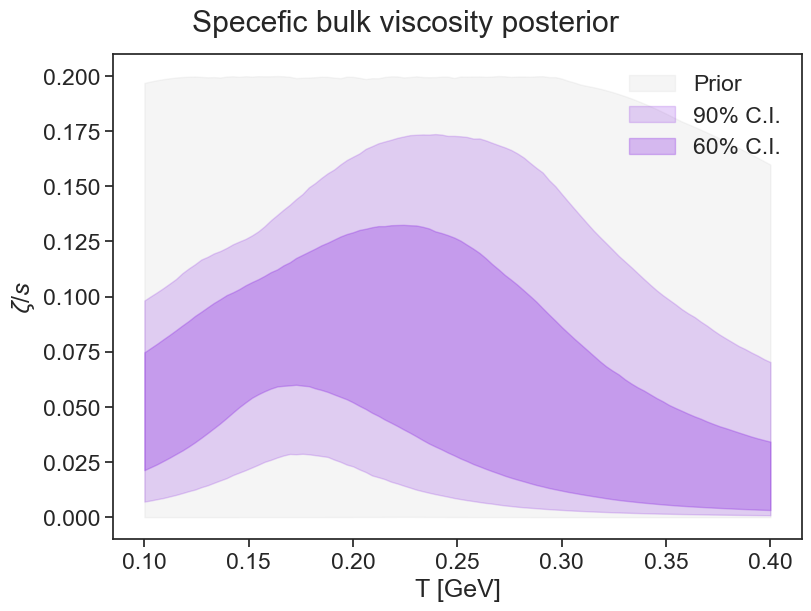

In [85]:
Tt = np.linspace(0.1, 0.4, 100)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,6),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic bulk viscosity posterior", wrap=True)

prior_zetas = []

for row in np.random.uniform(design_min, design_max,(10000,17))[:,[11,12,13,14]]:
    [zmax, T0, width, asym] = row   
    prior=[]
    for T in Tt:
        prior.append(zeta_over_s(T,zmax, T0, width, asym))
    prior_zetas.append(prior)
per0_pr,per5_pr,per20_pr,per80_pr,per95_pr,per100_pr=np.percentile(prior_zetas,[0,5,20,80,95,100], axis=0)

n_samples_posterior = 100000
prune = 10
posterior_zetas = []
    
for row in samples_df.iloc[0:n_samples_posterior:prune,[11,12,13,14]].values:
    [zmax, T0, width, asym] = row   
    posterior=[]
    for T in Tt:
        posterior.append(zeta_over_s(T,zmax, T0, width, asym))
    posterior_zetas.append(posterior)
per0,per5,per20,per80,per95,per100=np.percentile(posterior_zetas,[0,5,20,80,95,100], axis=0)
axes.fill_between(Tt, per0_pr,per100_pr,color=sns.color_palette()[7], alpha=0.1, label='Prior')
axes.fill_between(Tt,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
axes.fill_between(Tt,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
#pos=np.array(prior_zetas).T
#axes.violinplot(pos[1::10,:].T, positions=Tt[1::10],widths=0.03)

axes.legend(loc='upper right')
#axes.set_ylim(0,1.2)
axes.set_xlabel('T [GeV]')
axes.set_ylabel('$\zeta/s$')
save_fig('bulk_pos_ptemcee')

# Homework 
> Emulator validation

> Prior predictive checks

> Closure tests

> Tests for MCMC convergence

> Posterior predictive checks 
